<a href="https://colab.research.google.com/github/WaheedMomna/Assignment2/blob/main/Welcome_To_Colaboratory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import os
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from tqdm import tqdm
from collections import Counter
import torch.utils.data as data
import cv2
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import pandas as pd
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow




In [14]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!tar -xvf '/content/drive/MyDrive/A2/CS867 Sp2022_A2_Dataset/train_and_val_set.tar'

In [96]:
!ls train_set/images/

Streaming output truncated to the last 5000 lines.
145041.jpg  207400.jpg	269720.jpg  331880.jpg	393746.jpg  82526.jpg
145043.jpg  207405.jpg	269722.jpg  331881.jpg	39374.jpg   82527.jpg
145044.jpg  207406.jpg	269723.jpg  331882.jpg	393750.jpg  82528.jpg
145047.jpg  207407.jpg	269725.jpg  331883.jpg	393751.jpg  82529.jpg
145048.jpg  207408.jpg	269727.jpg  331884.jpg	393752.jpg  8252.jpg
145049.jpg  20740.jpg	269729.jpg  331885.jpg	393753.jpg  82531.jpg
14504.jpg   207410.jpg	269730.jpg  331886.jpg	393754.jpg  82532.jpg
145051.jpg  207411.jpg	269731.jpg  331887.jpg	393755.jpg  82533.jpg
145052.jpg  207414.jpg	269732.jpg  331888.jpg	393756.jpg  82534.jpg
145053.jpg  207416.jpg	269737.jpg  331890.jpg	393757.jpg  82535.jpg
145056.jpg  207417.jpg	269738.jpg  331891.jpg	393758.jpg  82537.jpg
145058.jpg  207418.jpg	26973.jpg   331892.jpg	393759.jpg  82538.jpg
145059.jpg  207419.jpg	269741.jpg  331893.jpg	39375.jpg   82539.jpg
14505.jpg   20741.jpg	269742.jpg  331894.jpg	393762.jpg  8253.jpg
1

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



160622.jpg  223023.jpg	285309.jpg  347413.jpg	409365.jpg  98150.jpg
160624.jpg  223026.jpg	285310.jpg  347414.jpg	409366.jpg  98151.jpg
160625.jpg  223027.jpg	285311.jpg  347415.jpg	409368.jpg  98152.jpg
160626.jpg  223028.jpg	285312.jpg  347417.jpg	409369.jpg  98155.jpg
160627.jpg  223029.jpg	285314.jpg  347418.jpg	409370.jpg  98157.jpg
160628.jpg  22302.jpg	285315.jpg  347419.jpg	409371.jpg  98158.jpg
160629.jpg  223030.jpg	285317.jpg  34741.jpg	409372.jpg  98159.jpg
16062.jpg   223031.jpg	285318.jpg  347420.jpg	409374.jpg  9815.jpg
160631.jpg  223032.jpg	285319.jpg  347421.jpg	409375.jpg  98160.jpg
160632.jpg  223033.jpg	285320.jpg  347422.jpg	409376.jpg  98163.jpg
160635.jpg  223035.jpg	285321.jpg  347423.jpg	409378.jpg  98165.jpg
160637.jpg  223036.jpg	285325.jpg  347424.jpg	40937.jpg   98167.jpg
160639.jpg  22303.jpg	285328.jpg  347425.jpg	409380.jpg  98168.jpg
160641.jpg  223040.jpg	285329.jpg  347426.jpg	409381.jpg  9816.jpg
160646.jpg  223041.jpg	28532.jpg   347427.jpg	409382.

In [23]:
image_size = 224
batch_size = 64
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Resize((image_size,image_size))])

In [ ]:
# path to our datset
data_path = '/content/train_set/images/'

#Initialize the dataset instance from the given datapath
data_set = torchvision.datasets.ImageFolder(root=data_path, transform=transform)


In [148]:
import numpy as np

anot = np.load('/content/train_set/annotations/90540_exp.npy', allow_pickle=True)


In [149]:
print(anot)
print(anot.shape)

6
()


In [158]:
import os
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Define a dictionary to convert expressions to integers
expressions_dict = {'Neutral': 0, 'Happy': 1, 'Sad': 2, 'Surprise': 3, 'Fear': 4, 'Disgust': 5, 'Anger': 6, 'Contempt': 7}

# Define a dictionary to map suffixes to variable names
suffixes_dict = {'_exp.npy': 'expression', '_aro.npy': 'arousal', '_val.npy': 'valence'}

class FaceDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.image_dir = os.path.join(root_dir, 'images')
        self.annotation_dir = os.path.join(root_dir, 'annotations')
        self.image_suffix = '.jpg'
        
        self.image_names = os.listdir(self.image_dir)
        self.annotation_names = [name.replace(self.image_suffix, '') for name in self.image_names]
        self.transform = transform
        
    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        image_name = self.image_names[idx]
        annotation_name = self.annotation_names[idx]
        
        # Load the image
        image_path = os.path.join(self.image_dir, image_name)
        image = Image.open(image_path)
        
        # Load the annotations
        annotation = {}
        for suffix, var_name in suffixes_dict.items():
            path = os.path.join(self.annotation_dir, annotation_name + suffix)
            if os.path.exists(path):
                annotation[var_name] = np.load(path, allow_pickle=True).item()
        
        if not annotation:
            print(f"No annotations found for {image_name}")
            return None
        
        # Check if expression label is valid
        expression_label = annotation.get('expression')
        # if expression_label is None or int(expression_label) not in expressions_dict:
        #     print(expression_label,': ',f"Unknown or missing expression label for {image_name}\n")
            
        #     return None
        
        # Get the values of the annotations
        expression = expression_label
        expression = int(expression)
        arousal = float(annotation.get('arousal'))
        valence = float(annotation.get('valence'))


        
        # Apply transform if provided
        if self.transform:
            image = self.transform(image)
        
        # Convert the annotations to PyTorch tensors
        expression = torch.tensor(expression, dtype=torch.long)
        arousal = torch.tensor(arousal, dtype=torch.float)
        valence = torch.tensor(valence, dtype=torch.float)
        
        return image, expression, arousal, valence


# Define the transforms to apply to the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalize with mean and standard deviation of 0.5
])

# Define the train dataset and data loader
dataset = FaceDataset('/content/train_set', transform=transform)

# Filter out examples with errors
#dataset = [d for d in dataset if d is not None]

# Calculate dataset sizes


# Calculate dataset sizes
dataset_size = len(dataset)
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size

# Split dataset into training and validation sets
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create DataLoader instances
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True, num_workers=2)


In [159]:

images, expression, arousal, valence = next(iter(train_loader))

# Denormalize the images (undo the normalization done in the transform)
#denormalized_images = images * torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)

# Print the shape of the images and labels
print(images.shape)
print(expression.shape)
print(arousal.shape)
print(valence.shape)

torch.Size([64, 3, 224, 224])
torch.Size([64])
torch.Size([64])
torch.Size([64])


In [115]:
image_suffix = '.jpg'
expression_suffix = '_exp.npy'
print('/content/train_set/annotations/281615.jpg'.replace(image_suffix,expression_suffix))

/content/train_set/annotations/281615_exp.npy


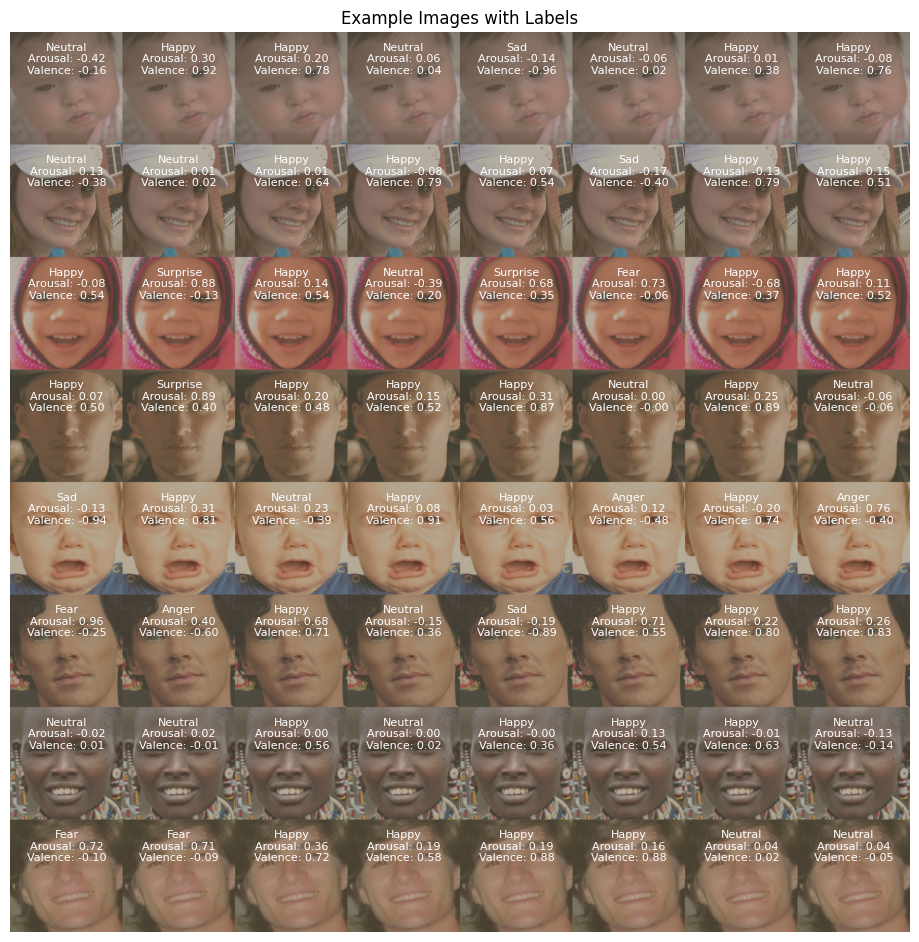

In [160]:
import matplotlib.pyplot as plt
import numpy as np

# Get a batch of images and labels from the DataLoader
images, expression, arousal, valence = next(iter(train_loader))

# Denormalize the images (undo the normalization done in the transform)
denormalized_images = images * torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)

# Convert PyTorch tensors to numpy arrays
denormalized_images = denormalized_images.numpy()
expression = expression.numpy()
arousal = arousal.numpy()
valence = valence.numpy()

# Create a grid of images
grid = np.concatenate([np.concatenate([denormalized_images[i] for i in range(8)], axis=1) for j in range(8)], axis=2)

# Create a list of label strings
expressions_dict_rev = {v: k for k, v in expressions_dict.items()}
labels = [f"{expressions_dict_rev[expression[i]]}\nArousal: {arousal[i]:.2f}\nValence: {valence[i]:.2f}" for i in range(64)]

# Plot the grid of images with labels
fig = plt.figure(figsize=(10, 10))
plt.imshow(grid.transpose((1, 2, 0)))
plt.axis('off')
plt.title('Example Images with Labels')
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, hspace=0.1, wspace=0.1)
for i, label in enumerate(labels):
    plt.text(i % 8 * 224 + 112, (i // 8) * 224 + 20, label, ha='center', va='top', fontsize=8, color='white')
